In [14]:
import numpy as np
from scipy.sparse import spdiags
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, ifft2
from scipy.integrate import solve_ivp
from scipy.linalg import lu, solve_triangular
import time

In [15]:
L = 10
n = 64
def onediag(n):
    N = np.ones(n**2)
    for i in range(0, n):
        N[n * (i + 1) - 1] = 0
    return N

def zerodiag(n):
    N = np.zeros(n**2)
    for i in range(0, n):
        N[n * i] = 1
    return N

data = np.array([-4*np.ones(n**2), onediag(n)[::-1], onediag(n), zerodiag(n)[::-1], zerodiag(n), np.ones(n**2), np.ones(n**2),  np.ones(n**2), np.ones(n**2)])
diags = [0, 1, -1, n - 1, 1 - n, n, -n, n**2 - n, n - n**2]
A0 = spdiags(data, diags, n**2, n**2).toarray()
A = A0/(((L-(-L))/n)**2)
A[0, 0] = 2

data = np.array([np.ones(n**2), -np.ones(n**2), -np.ones(n**2), np.ones(n**2)])
diags = [n, -n, n*(n-1), -n*(n-1)]
A0 = spdiags(data, diags, n**2, n**2).toarray()
B = A0/(2*((L-(-L))/n))

data = np.array([onediag(n)[::-1], -onediag(n), -zerodiag(n)[::-1], zerodiag(n)])
diags = [1, -1, n-1, 1-n]
A0 = spdiags(data, diags, n**2, n**2).toarray()
C = A0/(2*((L-(-L))/n))

print(A.shape, B.shape, C.shape)

(4096, 4096) (4096, 4096) (4096, 4096)


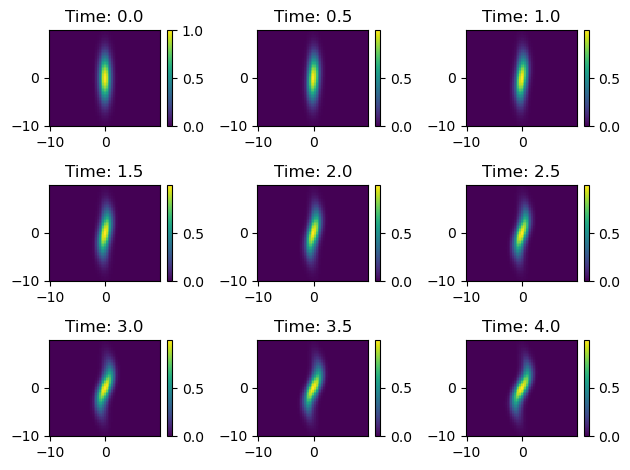

Elapsed time: 0.78 seconds
(4096, 9)
[[2.50656748e-46 3.57996136e-45 1.88106144e-44 ... 1.89120623e-42
  4.77616101e-42 1.13546131e-41]
 [1.17762859e-43 6.53684714e-43 2.62060728e-42 ... 1.58866490e-40
  3.55915954e-40 7.45533247e-40]
 [4.55107657e-41 1.93087628e-40 6.43663355e-40 ... 2.48966551e-38
  5.07459635e-38 9.69185374e-38]
 ...
 [1.96785570e-38 1.23636238e-37 5.46906656e-37 ... 4.35977114e-35
  1.02335874e-34 2.22858322e-34]
 [6.19028421e-41 5.34124949e-40 2.93882031e-39 ... 3.68664229e-37
  9.45501433e-37 2.23512843e-36]
 [1.60178709e-43 1.99879166e-42 1.41268009e-41 ... 2.80496038e-39
  7.96285821e-39 2.07493092e-38]]


In [16]:
tspan = np.linspace(0, 4, 9)
tshoot = [0, 4]
nu = 0.001
Lx, Ly = 20, 20
nx, ny = 64, 64
N = nx * ny

x2 = np.linspace(-Lx/2, Lx/2, nx + 1)
x = x2[:nx]
y2 = np.linspace(-Ly/2, Ly/2, ny + 1)
y = y2[:ny]
X, Y = np.meshgrid(x, y)
w = 1 * np.exp(- X**2 - Y**2/20)

kx = (2 * np.pi / Lx) * np.concatenate((np.arange(0, nx/2), np.arange(-nx/2, 0)))
kx[0] = 1e-6
ky = (2 * np.pi / Ly) * np.concatenate((np.arange(0, ny/2), np.arange(-ny/2, 0)))
ky[0] = 1e-6
KX, KY = np.meshgrid(kx, ky)
K = KX**2 + KY**2

start_time = time.time()
def spc_rhs(t, wt2, nx, ny, N, K, nu):
    wtc = wt2[0:N]
    wtN = wtc.reshape(N)
    wt = fft2(wtc.reshape((nx,ny)))
    psit = np.real(ifft2(-wt / K))
    psitN = psit.reshape(N)
    rhs = (nu * np.dot(A, wtN) - np.dot(B, psitN) * np.dot(C, wtN) + np.dot(C, psitN) * np.dot(B, wtN)).reshape(N)
    return rhs

w0 = w.reshape(N)
wtsol = solve_ivp(spc_rhs, tshoot, w0, t_eval = tspan, args=(nx, ny, N, K, nu), method = 'RK45')
end_time = time.time()
A1 = wtsol.y
for j, t in enumerate(tspan):
    wsol = wtsol.y[:,j].reshape((nx, ny))
    plt.subplot(3, 3, j+1)
    plt.pcolor(x, y, wsol)
    plt.title(f'Time: {t}')
    plt.colorbar()

plt.tight_layout()
plt.show()

elapsed_time = end_time- start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")
print(A1.shape)
print(A1)

Elapsed time: 57.13 seconds
(4096, 9)
[[ 2.50656748e-46 -1.78784704e-36  1.02706391e-36 ... -5.76806489e-26
  -6.68287054e-25  3.02050167e-24]
 [ 1.17762859e-43 -2.26093387e-29  1.85614646e-29 ... -1.48306461e-19
  -7.82424220e-19  1.67449651e-18]
 [ 4.55107657e-41 -4.24661881e-29  3.48720993e-29 ... -2.20165937e-20
  -2.91637720e-19  1.23961335e-18]
 ...
 [ 1.96785570e-38  7.20814729e-28 -6.58759786e-28 ...  4.01674620e-20
   1.34371413e-19 -8.94163775e-19]
 [ 6.19028421e-41  1.69117621e-28 -1.49205998e-28 ...  3.00460834e-20
   1.76009486e-19 -9.80736832e-19]
 [ 1.60178709e-43  5.05834665e-29 -4.38046443e-29 ...  2.47633369e-20
   1.15181522e-20  3.12761254e-20]]


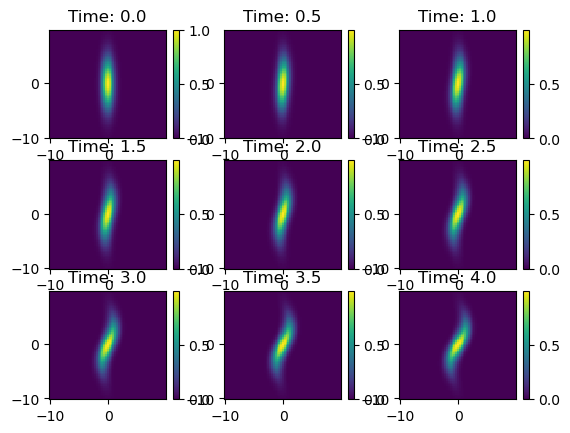

In [17]:
tspan = np.linspace(0, 4, 9)
tshoot = [0, 4]
nu = 0.001
Lx, Ly = 20, 20
nx, ny = 64, 64
N = nx * ny
A[0, 0] = 2

x2 = np.linspace(-Lx/2, Lx/2, nx + 1)
x = x2[:nx]
y2 = np.linspace(-Ly/2, Ly/2, ny + 1)
y = y2[:ny]
X, Y = np.meshgrid(x, y)
w = 1 * np.exp(- X**2 - Y**2/20)

start_time = time.time()
def spc_rhs2(t, wt2, nx, ny, N, nu):
    wtc = wt2[0:N]
    wt = wtc.reshape((nx, ny)) 
    wtN = wt.reshape(N)
    psit = np.linalg.solve(A, wtN)
    psitN = psit.reshape(N)
    rhs = (nu * np.dot(A, wtN) - np.dot(B, psitN) * np.dot(C, wtN) + np.dot(C, psitN) * np.dot(B, wtN)).reshape(N)
    return rhs

wt0 = w.reshape(N)
wtsol = solve_ivp(spc_rhs2, tshoot, wt0, t_eval = tspan, args=(nx, ny, N, nu), method = 'RK45')
end_time = time.time()
A2 = wtsol.y
for j, t in enumerate(tspan):
    wsol = wtsol.y[:N,j].reshape((nx, ny))

    plt.subplot(3, 3, j+1)
    plt.pcolor(x, y, wsol)
    plt.title(f'Time: {t}')
    plt.colorbar()

elapsed_time = end_time- start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")
print(A2.shape)
print(A2)

Elapsed time: 6.66 seconds
(4096, 9)
[[ 2.50656748e-46 -1.78784704e-36  1.02706391e-36 ... -5.76806489e-26
  -6.68287054e-25  3.02050167e-24]
 [ 1.17762859e-43 -2.26093387e-29  1.85614646e-29 ... -1.48306461e-19
  -7.82424220e-19  1.67449651e-18]
 [ 4.55107657e-41 -4.24661881e-29  3.48720993e-29 ... -2.20165937e-20
  -2.91637720e-19  1.23961335e-18]
 ...
 [ 1.96785570e-38  7.20814729e-28 -6.58759786e-28 ...  4.01674620e-20
   1.34371413e-19 -8.94163775e-19]
 [ 6.19028421e-41  1.69117621e-28 -1.49205998e-28 ...  3.00460834e-20
   1.76009486e-19 -9.80736832e-19]
 [ 1.60178709e-43  5.05834665e-29 -4.38046443e-29 ...  2.47633369e-20
   1.15181522e-20  3.12761254e-20]]


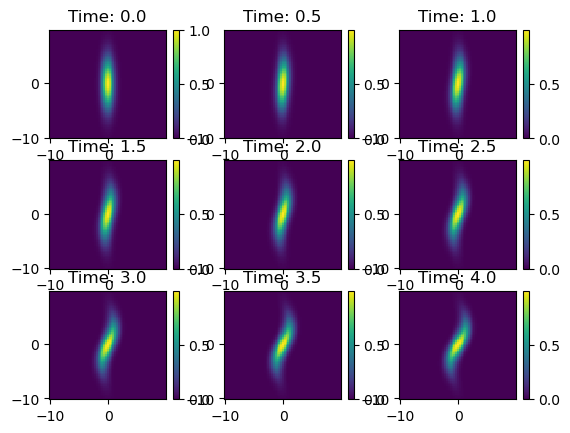

In [18]:
tspan = np.linspace(0, 4, 9)
tshoot = [0, 4]
nu = 0.001
Lx, Ly = 20, 20
nx, ny = 64, 64
N = nx * ny
A[0, 0] = 2

x2 = np.linspace(-Lx/2, Lx/2, nx + 1)
x = x2[:nx]
y2 = np.linspace(-Ly/2, Ly/2, ny + 1)
y = y2[:ny]
X, Y = np.meshgrid(x, y)
w = 1 * np.exp(- X**2 - Y**2/20)

start_time = time.time()
P, L, U = lu(A)
def spc_rhs3(t, wt2, nx, ny, N, nu):
    wtc = wt2[0:N]
    wt = wtc.reshape((nx, ny)) 
    wtN = wt.reshape(N)
    Pb = np.dot(P, wtN)
    y = solve_triangular(L, Pb, lower=True)
    psit = solve_triangular(U, y)
    psitN = psit.reshape(N)
    rhs = (nu * np.dot(A, wtN) - np.dot(B, psitN) * np.dot(C, wtN) + np.dot(C, psitN) * np.dot(B, wtN)).reshape(N)
    return rhs

wt0 = w.reshape(N)
wtsol = solve_ivp(spc_rhs3, tshoot, wt0, t_eval = tspan, args=(nx, ny, N, nu), method = 'RK45')
end_time = time.time()
A3 = wtsol.y
for j, t in enumerate(tspan):
    wsol = wtsol.y[:N,j].reshape((nx, ny))
    plt.subplot(3, 3, j+1)
    plt.pcolor(x, y, wsol)
    plt.title(f'Time: {t}')
    plt.colorbar()

elapsed_time = end_time- start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")
print(A3.shape)
print(A3)